In [1]:
# import packages
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix
#
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

Download csv files to working directory

In [2]:
# load data
df1 = pd.read_csv("./attributes_4dpf_wt_equalized.csv")
df2 = pd.read_csv("./attributes_4dpf_hht_equalized.csv")
df3 = pd.read_csv("./attributes_5dpf_wt_equalized.csv")
df4 = pd.read_csv("./attributes_5dpf_hht_equalized.csv")
# combine csvs for convenience in plotting later
df1['Sample'] = '4dpf_WT'
df2['Sample'] = '4dpf_HHT'
df3['Sample'] = '5dpf_WT'
df4['Sample'] = '5dpf_HHT'
df1['Genotype'] = 'WT'
df2['Genotype'] = 'HHT'
df3['Genotype'] = 'WT'
df4['Genotype'] = 'HHT'
wt = pd.concat([df1, df3], axis=0)
hht = pd.concat([df2, df4], axis=0)
phat = pd.concat([df1, df2, df3, df4], axis=0)
# visualize initial distributions
# sns.jointplot(data = phat, x = "Volume", y = "Flatness", hue = "Sample")
sns.set_context("paper")
# color palette as dictionary
palette = {"WT":"tab:blue",
           "HHT":"tab:red", 
           "4dpf_WT":"tab:pink",
           "4dpf_HHT":"firebrick",
           "5dpf_WT":"navy", 
           "5dpf_HHT":"darkorange"}
# https://matplotlib.org/stable/gallery/color/named_colors.html

Plot distribution of cell volumes

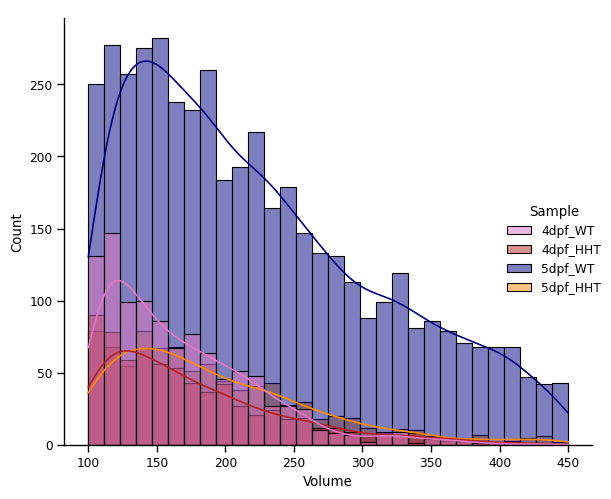

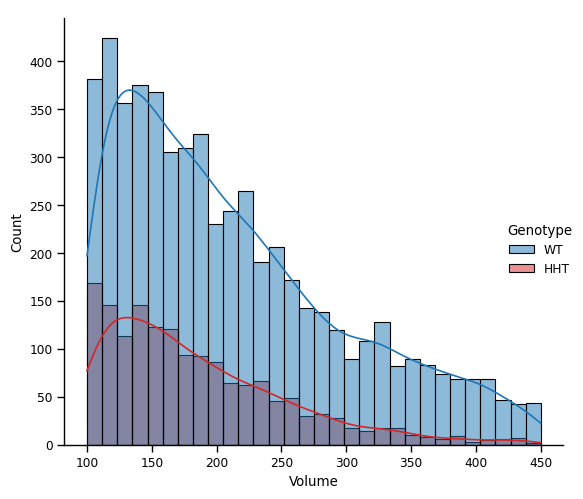

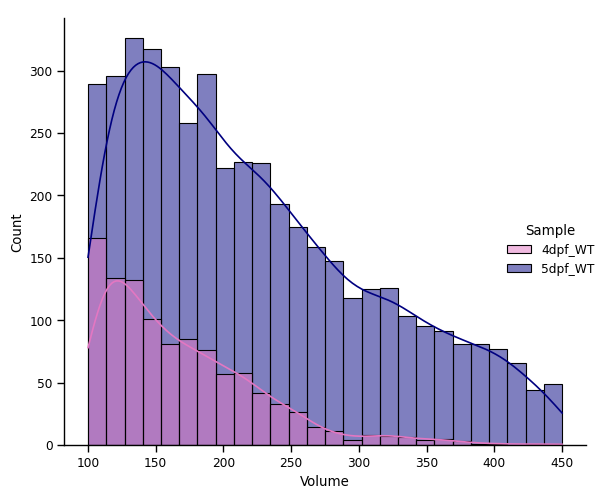

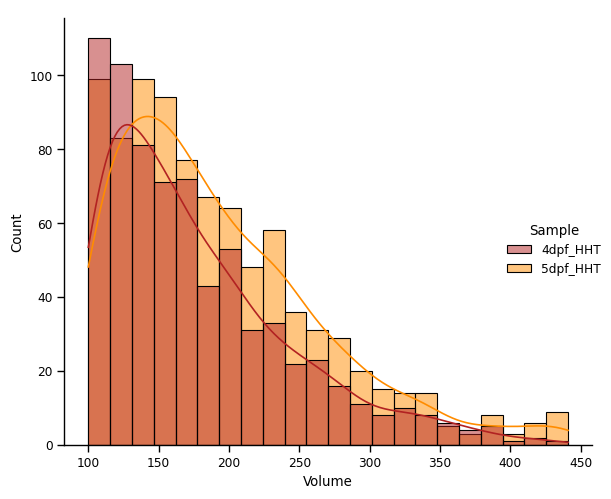

In [3]:
g = sns.displot(data=phat, x="Volume", hue="Sample", palette=palette, kde=True)
g.add_legend(loc='upper right')
plt.savefig("all4hist.png")
f = sns.displot(data=phat, x="Volume", hue="Genotype", palette=palette, kde=True)
f.add_legend(loc='upper right')
plt.savefig("genotype.png")
h = sns.displot(data=wt, x="Volume", hue="Sample", palette=palette, kde=True)
h.add_legend(loc='upper right')
plt.savefig("wt.png")
i = sns.displot(data=hht, x="Volume", hue="Sample", palette=palette, kde=True)
i.add_legend(loc='upper right')
plt.savefig("hht.png")

Compare means across all groups

In [4]:
# define function that takes in two columns of a pandas df and calculates their std
# then completes a t test of independence conditional upon whether they have equal variance
def compare_means(a, b):
    vara = a.var()
    varb = a.var()
    if vara == varb:
        w = ttest_ind(a, b)
        return(w)
    elif vara != varb:
        w = ttest_ind(a, b, equal_var=False)
        return(w)
    print(w)
# Compare all groups for a chosen feature (volume, flatness, etc)
fivecomp = compare_means(df1['Volume'], df2['Volume'])
fourcomp = compare_means(df3['Volume'], df4['Volume'])
wtvs5hht = compare_means(df1['Volume'], df4['Volume'])
fourhhtvs5hht = compare_means(df2['Volume'], df4['Volume'])
fourwtvs5wt = compare_means(df2['Volume'], df3['Volume'])
bigwtvshht = compare_means(wt['Volume'], hht['Volume'])

# Welch's T test for wt vs hht overall:
# ttest_ind(wt['Volume'], hht['Volume'])
a = compare_means(wt['Volume'], hht['Volume'])
print(a)

Ttest_indResult(statistic=11.361946334683253, pvalue=1.1615247493824535e-29)


182.78982800754576 3.393131698498664e-114


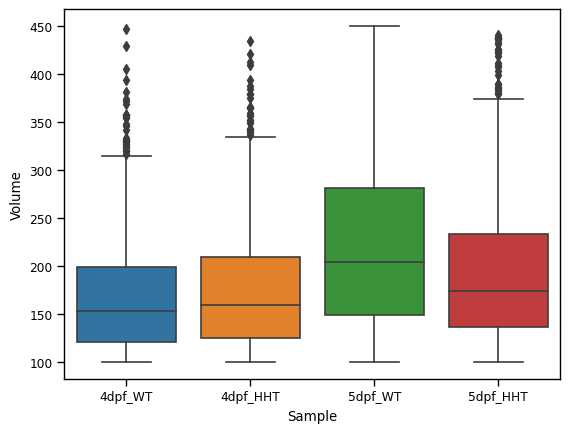

In [5]:
sns.boxplot(x='Sample', y='Volume', data=phat)#color='#99c2a2'
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(df1["Volume"], df2['Volume'], df3['Volume'], df4['Volume'])
print(fvalue, pvalue)

Linear Discriminant Analysis for Classification 

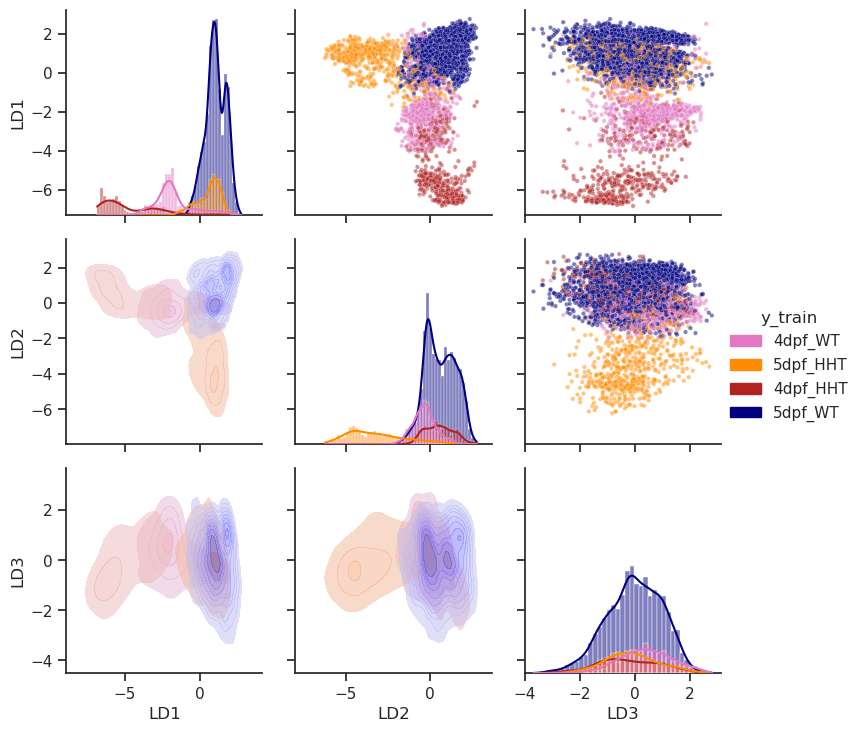

In [6]:
# drop redundant columns/those containing null
phatdrop = phat.drop(['Label', 'Radius','IntensitySkewness', ' IntensityMean',
       ' IntensitySTD', ' IntensityKurtosis'], axis = 1)
#
X = phatdrop.iloc[:, 0:8].values
y = phatdrop.iloc[:, 9].values

# check null
phatdrop.isnull().sum()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
# PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train, y_train)
# LDA
lda = LDA(n_components=3)
X_lda = lda.fit_transform(X_train, y_train)
y_lda = lda.transform(X_test)
# Convert your X_lda array to a pandas DataFrame
df = pd.DataFrame(X_lda, columns=['LD1', 'LD2', 'LD3'])
df['y_train'] = y_train

# Create a scatter plot matrix using Seaborn
sns.set(style='ticks')
g = sns.PairGrid(df, hue='y_train', palette=palette)
g.map_upper(sns.scatterplot, s=10, alpha=0.5)
g.map_lower(sns.kdeplot, fill=True, alpha=0.5)
g.map_diag(sns.histplot, kde=True, alpha=0.5)
g.add_legend()
plt.savefig("LDA_2.png")